# Imports

In [1]:
from utils.imports import *
from utils.data_loader import download_data, load_data
from utils.models import PretrainedModel, AlexNetVanilla
from utils.utils import preprocess_images, get_current_time
from utils.config import batch_size, num_epochs, model_str

# Initialize data

In [2]:
fnames = ["../kay_labels.npy", "../kay_labels_val.npy", "../kay_images.npz"]
urls = ["https://osf.io/r638s/download",
        "https://osf.io/yqb3e/download",
        "https://osf.io/ymnjv/download"]

if download_data(fnames, urls):
    init_training_inputs, init_test_inputs, training_outputs, test_outputs, roi, roi_names, labels, val_labels = load_data('../kay_images.npz')

# Preprocessing

### Outlier detection and handling

In a normal distribution, 99.7% of the data is within +/- 3 standard deviations of the mean. We can use this to identify outliers in the data. 

Next is deciding on how to handle outliers, e.g.:

- Exclude Outliers: Exclude any voxels that are outliers in any of the images. This is a stringent approach but ensures that your model is not influenced by these extreme values.
- Exclude Outliers on a Per-Image Basis: Instead of excluding a voxel across all images, you could exclude it only for those specific images where it's an outlier. This retains more data but can complicate the modeling process.
- Winsorize Outliers: Instead of excluding outliers, you can cap them at the nearest non-outlier value (e.g., set all values above 3 to 3 and all below -3 to -3). This method reduces the impact of extreme values without losing data.
- Replace with mean: We can replace outliers with the mean of the data. This is a simple approach, but it can introduce bias into the dataset.

In [3]:
# TRAINING DATA
# Train data shape
print("(Train) Responses shape: ", training_outputs.shape)

# Total number of voxels
print("(Train) Total number of voxels: ", training_outputs.size)

# For all images, count how many voxels are outside the range [-3, 3] Z-score.
print("(Train) Number of voxels outside [-3, 3] Z-score: ",
        np.sum(np.abs(training_outputs) > 3))

# Ratio of voxels outside [-3, 3] Z-score
print("(Train) Ratio of voxels outside [-3, 3] Z-score compared to total: ",
        np.sum(np.abs(training_outputs) > 3) / training_outputs.size * 100, "%")

# How many distinct responses have an outlier voxel?
print("(Train) Number of distinct responses with outlier voxel: ",
        np.unique(np.where(np.abs(training_outputs) > 3)[0]).size)

# Count distinct voxels that are outliers and how many times that specific voxel is an outlier
outlier_voxels, outlier_counts = np.unique(np.where(np.abs(training_outputs) > 3)[1], return_counts=True)
print("(Train) Number of distinct outlier voxels: ", outlier_voxels.size)
print("(Train) Number of times each outlier voxel is an outlier: ", outlier_counts)

# Max and min in outlier_counts
print("(Train) Max number of times an outlier voxel is an outlier: ", np.max(outlier_counts))
print("(Train) Min number of times an outlier voxel is an outlier: ", np.min(outlier_counts))

(Train) Responses shape:  (1750, 8428)
(Train) Total number of voxels:  14749000
(Train) Number of voxels outside [-3, 3] Z-score:  51365
(Train) Ratio of voxels outside [-3, 3] Z-score compared to total:  0.348260899044003 %
(Train) Number of distinct responses with outlier voxel:  1748
(Train) Number of distinct outlier voxels:  8402
(Train) Number of times each outlier voxel is an outlier:  [6 4 8 ... 2 7 6]
(Train) Max number of times an outlier voxel is an outlier:  22
(Train) Min number of times an outlier voxel is an outlier:  1


In [4]:
# TEST DATA
# Test data shape
print("(Test) Responses shape: ", test_outputs.shape)

# Total number of voxels
print("(Test) Total number of voxels: ", test_outputs.size)

# For all images, count how many voxels are outside the range [-3, 3] Z-score.
print("(Test) Number of voxels outside [-3, 3] Z-score: ",
        np.sum(np.abs(test_outputs) > 3))

# Ratio of voxels outside [-3, 3] Z-score
print("(Test) Ratio of voxels outside [-3, 3] Z-score compared to total: ",
        np.sum(np.abs(test_outputs) > 3) / test_outputs.size * 100, "%")

# How many distinct responses have an outlier voxel?
print("(Test) Number of distinct responses with outlier voxel: ",
        np.unique(np.where(np.abs(test_outputs) > 3)[0]).size)

# Count distinct voxels that are outliers and how many times that specific voxel is an outlier
outlier_voxels, outlier_counts = np.unique(np.where(np.abs(test_outputs) > 3)[1], return_counts=True)
print("(Test) Number of distinct outlier voxels: ", outlier_voxels.size)
print("(Test) Number of times each outlier voxel is an outlier: ", outlier_counts)

(Test) Responses shape:  (120, 8428)
(Test) Total number of voxels:  1011360
(Test) Number of voxels outside [-3, 3] Z-score:  37
(Test) Ratio of voxels outside [-3, 3] Z-score compared to total:  0.00365844012023414 %
(Test) Number of distinct responses with outlier voxel:  21
(Test) Number of distinct outlier voxels:  27
(Test) Number of times each outlier voxel is an outlier:  [ 1  1  1  1  1  1 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  1  1]


### Transformations and normalization to fit PyTorch models

In [5]:
# Preprocess the images
training_inputs = preprocess_images(init_training_inputs)
test_inputs = preprocess_images(init_test_inputs)

In [6]:
# Print shapes of the preprocessed data
print("Training input shape:", training_inputs.shape)
print("Test input shape:", test_inputs.shape)

Training input shape: (1750, 3, 224, 224)
Test input shape: (120, 3, 224, 224)


### Reducing output size to number of ROI's instead of voxels

In [7]:
# Preprocess outputs to be the mean of each ROI instead of each voxel.
# This reduces the outputs to be predicted from 8428 to 7, hopefully not losing too much detail in the data in the process.
def reduce_outputs_to_ROIs(outputs):
    roi_count_dict = dict(zip(roi_names, np.bincount(roi)))
    roi_order = np.argsort(roi)
    sorted_responses = training_outputs[:, roi_order]

    training_outputs_reduced_to_ROIs = np.zeros((len(outputs), 7))
    for sample in range(len(training_outputs_reduced_to_ROIs)):
        oldValue = 0
        count = 0
        for key, value in roi_count_dict.items():
            if value > 0:
                response_values = sorted_responses[:, oldValue:oldValue+value]
                summed_roi = np.mean(response_values[sample])
                training_outputs_reduced_to_ROIs[sample][count] = summed_roi
                count += 1
            oldValue = value
    return training_outputs_reduced_to_ROIs

print(reduce_outputs_to_ROIs(training_outputs).shape)
print('Example values:', reduce_outputs_to_ROIs(training_outputs)[0])

(1750, 7)
Example values: [-0.23860244 -0.12070409 -0.10817796 -0.14121429 -0.33175569 -0.19762734
 -0.11004769]


# Encoder model

## Model setup

In [8]:
class Encoder():
    def __init__(self, input, output, model_str):
        self.input = input
        self.output = output
        self.losses = []
        self.best_loss = 1000000
        self.model_str = model_str
    
    # Method for setting up model and needed elements for it to be trained
    def setup_model(self, batch_size):
        # Seperate data
        x_train = self.input
        y_train = self.output

        # Create tensor from training inputs and targets
        x_train_tensor, y_train_tensor = torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float()
        training_data_tensor = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)

        # Create dataloader from tensor
        train_dataloader = torch.utils.data.DataLoader(training_data_tensor, batch_size, shuffle=True)

        # Create encoder model
        encoder_model = PretrainedModel(model_str=self.model_str)
        
        # MSELoss instead of CrossEntropy beause it is more of a regression problem than classification
        criterion = nn.MSELoss()
        
        # Freeze all layers except the classifier
        for name, param in encoder_model.named_parameters():
            if "classifier" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        # Optimizer
        optimizer = optim.Adam(encoder_model.parameters(), lr=0.0001)
        # optimizer = optim.SGD(encoder_model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-6, nesterov=True) # Old optimizer

        return encoder_model, criterion, optimizer, train_dataloader

    # Method for training the model one epoch
    def train_one_epoch(self, train_dataloader, optimizer, criterion, encoder, epoch):
        train_running_loss = 0.0
        last_loss = 0.0

        # Put the model in training mode
        encoder = encoder.train()

        # Iterate through the data
        for i, data in enumerate(train_dataloader):
            inputs, targets = data

            outputs = encoder(inputs.float())
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()

            # Update model params
            optimizer.step()

            train_running_loss += loss.detach().item()
            last_loss = loss.detach().item()
            
        return last_loss

    # Method for training the model fully
    def train(self, batch_size, num_epochs):
        timestamp = get_current_time()
        
        # Setup model
        encoder_model, criterion, optimizer, train_dataloader = self.setup_model(batch_size)
        
        # Training
        train_running_loss = 0.0
        for epoch in range(num_epochs):
            train_running_loss = self.train_one_epoch(train_dataloader, optimizer, criterion, encoder_model, epoch)
            self.losses.append(train_running_loss)

            if train_running_loss < self.best_loss:
                self.best_loss = train_running_loss
                best_model = encoder_model.state_dict()
                torch.save(best_model, os.path.join('../trained_models/', '{}_{}_{}.pth'.format(model_str, num_epochs, timestamp)))

            # Print loss value after each epoch
            print('Epoch: {} | Loss: {}'.format((epoch + 1), train_running_loss))
        
            if (epoch + 1) % 10 == 0:
                # Plot loss curve
                plt.figure(figsize=(10, 5))
                plt.title(f'{model_str} - Encoder Loss')
                plt.plot(self.losses, label="Encoder Loss")
                plt.xlabel("Iterations")
                plt.ylabel("Epoch")
                plt.legend()

                if epoch == num_epochs - 1:
                    save_dir = '../loss_plots/'

                    # Check if the directory exists
                    if not os.path.exists(save_dir):
                        os.makedirs(save_dir)  # Create the directory if it does not exist

                    # Save plot of loss curve. Format: loss_{num_epochs}_{timestamp].png
                    plt.savefig(os.path.join(save_dir, f'{model_str}_loss_{num_epochs}_{timestamp}.png'))

                plt.show()

        return encoder_model

# Training the model

Original input data shape: (1750, 3, 224, 224)
Original outputs data shape: (1750, 8428)

Running with parameters:
     Batch size: 128
     Number of epochs: 50
     Model: ResNet50

Epoch: 1 | Loss: 1.0082902908325195
Epoch: 2 | Loss: 0.996986985206604
Epoch: 3 | Loss: 1.00251305103302
Epoch: 4 | Loss: 1.0117216110229492
Epoch: 5 | Loss: 0.9968029260635376
Epoch: 6 | Loss: 0.9342864155769348
Epoch: 7 | Loss: 0.9670823216438293
Epoch: 8 | Loss: 0.9534623026847839
Epoch: 9 | Loss: 0.9820154905319214
Epoch: 10 | Loss: 0.9571859836578369


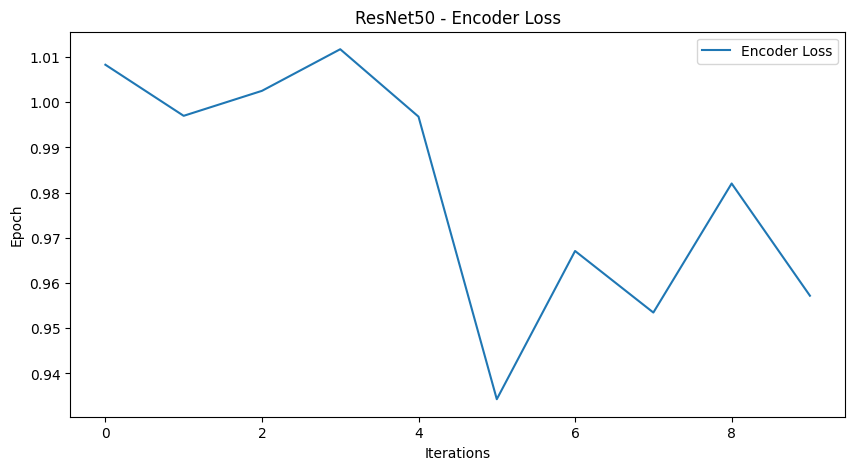

Epoch: 11 | Loss: 0.9817501902580261
Epoch: 12 | Loss: 0.9459958076477051
Epoch: 13 | Loss: 0.944456160068512
Epoch: 14 | Loss: 0.9449391961097717
Epoch: 15 | Loss: 0.9357802271842957
Epoch: 16 | Loss: 0.9521260261535645
Epoch: 17 | Loss: 0.9154801368713379
Epoch: 18 | Loss: 0.9335473775863647
Epoch: 19 | Loss: 0.9269344210624695
Epoch: 20 | Loss: 0.9517228007316589


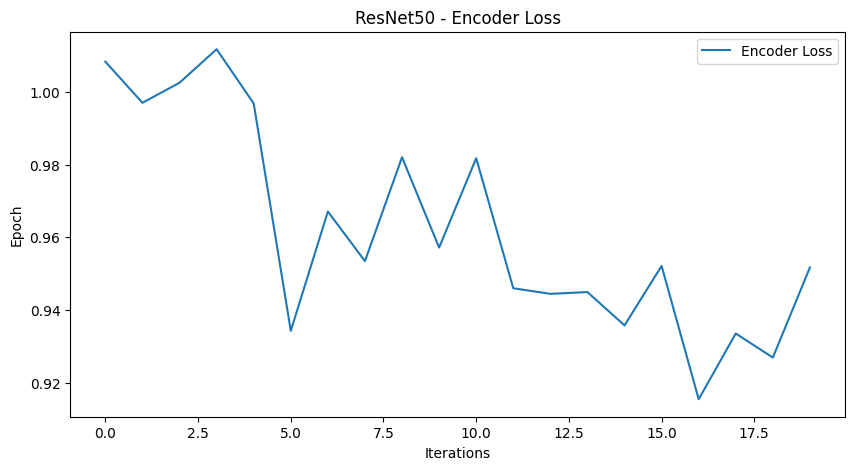

Epoch: 21 | Loss: 0.923831582069397
Epoch: 22 | Loss: 0.9165605902671814
Epoch: 23 | Loss: 0.93375563621521
Epoch: 24 | Loss: 0.9040359854698181
Epoch: 25 | Loss: 0.9021280407905579
Epoch: 26 | Loss: 0.9091262221336365
Epoch: 27 | Loss: 0.8928428888320923
Epoch: 28 | Loss: 0.9168217778205872
Epoch: 29 | Loss: 0.9191382527351379
Epoch: 30 | Loss: 0.9197932481765747


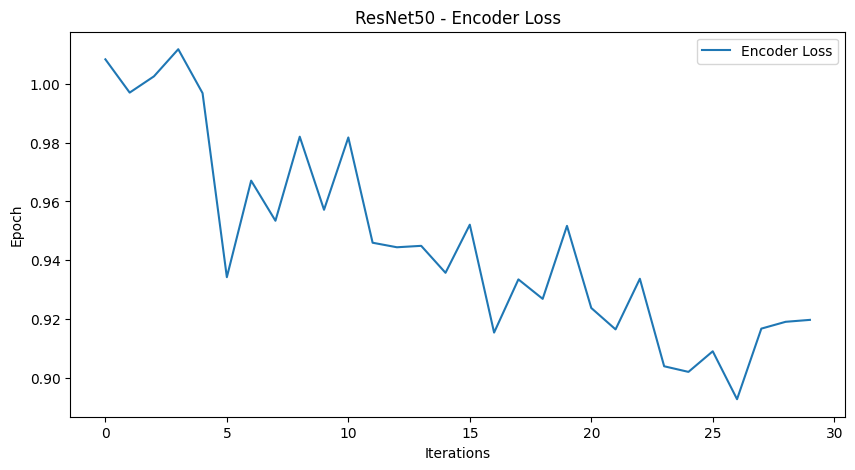

Epoch: 31 | Loss: 0.8853504061698914
Epoch: 32 | Loss: 0.8602345585823059
Epoch: 33 | Loss: 0.9280446767807007
Epoch: 34 | Loss: 0.8329782485961914
Epoch: 35 | Loss: 0.8719808459281921
Epoch: 36 | Loss: 0.871646523475647
Epoch: 37 | Loss: 0.8842354416847229
Epoch: 38 | Loss: 0.874067485332489
Epoch: 39 | Loss: 0.8960127830505371
Epoch: 40 | Loss: 0.8541898131370544


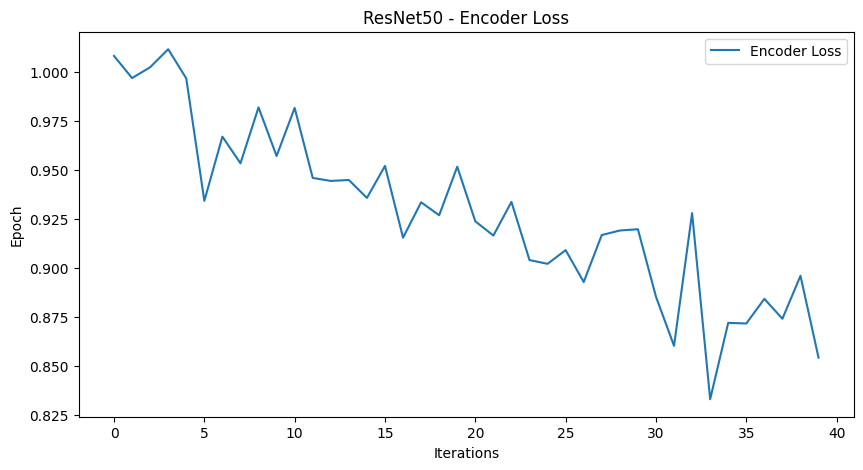

Epoch: 41 | Loss: 0.8665218949317932
Epoch: 42 | Loss: 0.8636618852615356
Epoch: 43 | Loss: 0.865366518497467
Epoch: 44 | Loss: 0.901232898235321
Epoch: 45 | Loss: 0.8675291538238525
Epoch: 46 | Loss: 0.8876686096191406
Epoch: 47 | Loss: 0.8802085518836975
Epoch: 48 | Loss: 0.8531844615936279
Epoch: 49 | Loss: 0.8301205039024353
Epoch: 50 | Loss: 0.815160870552063


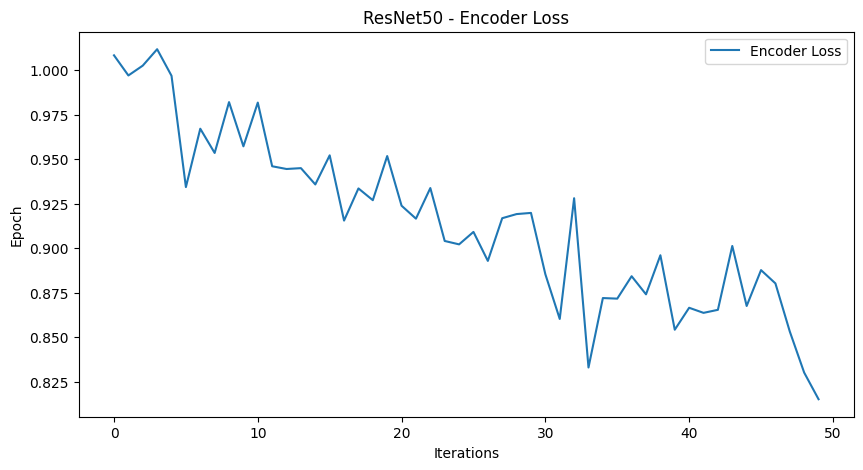

In [9]:
print('Original input data shape:', training_inputs.shape)
print('Original outputs data shape:', training_outputs.shape)
print('')
print('Running with parameters:')
print('     Batch size:', batch_size)
print('     Number of epochs:', num_epochs)
print('     Model:', model_str)
print('')

# Setup model and train it
encoder = Encoder(training_inputs, training_outputs, model_str)
trained_model = encoder.train(batch_size=batch_size, num_epochs=num_epochs)